# Importing Libraries

In [1]:
import tensorflow as tf
from glob import glob
from tensorflow import keras
import numpy as np

from sklearn.model_selection import train_test_split
import cv2

import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.optimizers import Adam

from tensorflow.keras.metrics import *

2025-02-20 18:00:41.581052: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-20 18:00:41.590630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740074441.601104    9364 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740074441.603995    9364 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-20 18:00:41.617902: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    try:
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        print("Enabled memory growth for GPU")
    except RuntimeError as e:
        print(e)


Enabled memory growth for GPU


# Arranging the Dataset

In [3]:
import cv2
import numpy as np
import os
from glob import glob

def load_image(path, size):
    """Load and resize an image."""
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale (modify if needed)
    if img is None:
        return None
    img = cv2.resize(img, (size, size))  # Resize image
    img = img.astype(np.float32) / 255.0  # Normalize pixel values to [0,1]
    return img

def load_data(root_path, size):
    """Load images and corresponding masks from the dataset folder."""
    images = []
    masks = []

    # Get all image paths recursively
    image_paths = sorted(glob(os.path.join(root_path, "**", "*.png"), recursive=True))

    if len(image_paths) == 0:
        raise FileNotFoundError(f"No images found in: {root_path}")

    for path in image_paths:
        if "_mask" in path:  # Skip masks in this loop, we'll load them separately
            continue  

        img = load_image(path, size)
        if img is None:
            print(f"Warning: Could not load image {path}")
            continue

        # Construct the corresponding mask path
        mask_path = path.replace(".png", "_mask.png")

        if os.path.exists(mask_path):
            mask = load_image(mask_path, size)
            if mask is None:
                print(f"Warning: Could not load mask {mask_path}")
                continue
        else:
            print(f"Warning: Mask not found for {path}")
            continue

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

# Define dataset path (without wildcard `*`)
dataset_path = "/home/gokul/my_projects/Breast Cancer Detection/Dataset_BUSI_with_GT"
image_size = 256  # Set the image size

# Load images and masks
images, masks = load_data(dataset_path, image_size)

# Reshape masks to match model output
masks = masks[..., np.newaxis]  # Add channel dimension

# Print dataset shape
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)


Images shape: (780, 256, 256)
Masks shape: (780, 256, 256, 1)


In [4]:
from sklearn.model_selection import train_test_split

# Split dataset
X_train, X_val, Y_train, Y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


# Model Architecture

In [5]:
def conv_block(input, num_filters):
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal")(input)
    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal")(conv)
    return conv

def encoder_block(input, num_filters):
    conv = conv_block(input, num_filters)
    pool = MaxPooling2D((2, 2))(conv)
    return conv, pool

def decoder_block(input, skip_features, num_filters):
    uconv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = concatenate([uconv, skip_features])
    conv = conv_block(con, num_filters)
    return conv

def build_model(input_shape):
    input_layer = Input(input_shape)

    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bottleneck Layer
    bottleneck = conv_block(p4, 1024)

    d1 = decoder_block(bottleneck, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    output_layer = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)

    model = Model(input_layer, output_layer, name="U-Net")
    return model

# Define the model architecture and compile it
size = 256  # Assuming a default size, change if needed
model = build_model(input_shape=(size, size, 1))
model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

I0000 00:00:1740074454.571584    9364 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


# Training

In [6]:
batch_size = 8
epochs = 50

# Train the model
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1
)

Epoch 1/50


I0000 00:00:1740074471.369671    9467 service.cc:148] XLA service 0x7f80bc034da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740074471.369751    9467 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-02-20 18:01:11.458317: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740074471.854088    9467 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-20 18:01:13.467802: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:378] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller

78/78 ━━━━━━━━━━━━━━━━━━━━ 65s 440ms/step - accuracy: 0.9155 - loss: 0.4773 - val_accuracy: 0.9225 - val_loss: 0.2742
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 22s 284ms/step - accuracy: 0.9174 - loss: 0.2805 - val_accuracy: 0.9226 - val_loss: 0.2896
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 21s 271ms/step - accuracy: 0.9204 - loss: 0.2751 - val_accuracy: 0.9225 - val_loss: 0.2544
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 22s 285ms/step - accuracy: 0.9216 - loss: 0.2627 - val_accuracy: 0.9225 - val_loss: 0.2467
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 22s 285ms/step - accuracy: 0.9241 - loss: 0.2344 - val_accuracy: 0.9233 - val_loss: 0.2500
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 21s 274ms/step - accuracy: 0.9258 - loss: 0.2177 - val_accuracy: 0.9237 - val_loss: 0.2037
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 22s 287ms/step - accuracy: 0.9229 - loss: 0.2198 - val_accuracy: 0.9225 - val_loss: 0.2106
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 22s 287ms/step - accuracy: 0.9201 - loss: 0.2316 - val_accuracy: 0.922

# Evaluation on Test

In [10]:
val_loss, val_acc = model.evaluate(X_val, Y_val)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")


model.save("unet_segmentation_model.h5")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - accuracy: 0.9547 - loss: 0.1572


Validation Loss: 0.1609, Validation Accuracy: 0.9541


# For Further Predictions

2025-02-21 08:07:18.075033: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-21 08:07:18.409690: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740125238.532439     516 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740125238.571021     516 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-21 08:07:18.881124: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Model loaded successfully!


I0000 00:00:1740125261.644696     608 service.cc:148] XLA service 0x7fb09800d810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740125261.645383     608 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-02-21 08:07:41.686380: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740125261.858660     608 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-21 08:07:44.111622: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-21 08:07:44.892077: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_b

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


I0000 00:00:1740125267.513192     608 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


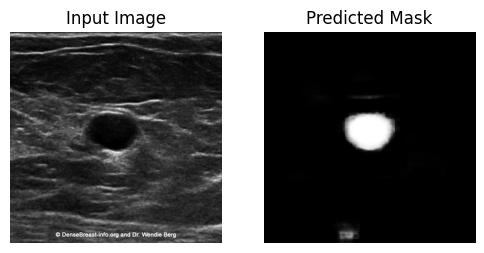

In [ ]:
import tkinter as tk
from tkinter import filedialog
import cv2
import numpy as np
import tensorflow as tf
from PIL import Image, ImageTk
import matplotlib.pyplot as plt

# Load the trained model
model_path = "/home/gokul/unet_segmentation_model.h5"

try:
    model = tf.keras.models.load_model(model_path)
    print("Model loaded successfully!")
except Exception as e:
    print("Error loading model:", e)


def load_image():
    # Open a file dialog to select an image
    file_path = filedialog.askopenfilename(
        title="Select an Image",
        filetypes=[("PNG Images", "*.png"), ("All Files", "*.*")]
    )
    if not file_path:
        return

    # Load and preprocess the image
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256)) / 255.0  # Normalize
    img = np.expand_dims(img, axis=(0, -1))  # Shape: (1, 256, 256, 1)

    # Predict the mask
    pred_mask = model.predict(img)[0, :, :, 0]

    # Display images
    display_images(file_path, pred_mask)


def display_images(image_path, pred_mask):
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].imshow(Image.open(image_path).convert("L"), cmap="gray")
    ax[0].set_title("Input Image")
    ax[0].axis("off")

    ax[1].imshow(pred_mask, cmap="gray")
    ax[1].set_title("Predicted Mask")
    ax[1].axis("off")

    plt.show(block=False)  # Allow GUI to remain responsive


# Create the GUI window
root = tk.Tk()
root.title("Breast Cancer Detection")
root.geometry("400x200")

label = tk.Label(root, text="Select an Image for Mask Prediction", font=("Arial", 12))
label.pack(pady=10)

btn = tk.Button(root, text="Choose Image", command=load_image, font=("Arial", 12))
btn.pack(pady=10)

root.mainloop()
